In [ ]:
#!pip install xlrd

In [2]:
import os
import datetime as dt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
def transform_johns_hopkins(df):
    df = df.groupby('Country/Region').sum()
    cols = list(df.columns)
    cols.remove('Lat')
    cols.remove('Long')
    df = df[cols]
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df.index.name = "Date"
    return df#[columns]

def get_johns_hopkins(kind='confirmed'):
    assert kind in ['confirmed', 'deaths', 'recovered']
    url = f"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{kind}_global.csv"
    df = pd.read_csv(url)
    df = transform_johns_hopkins(df)
    fname = f"data/CSSEGUSandData/time_series_covid19_{kind}_global.csv"
    df.to_csv(fname)
    return df

In [4]:
def transform_sinave_eduardofv(df):
    df = df.groupby('Estado').sum()
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
    df.index.name = "Date"
    return df#[columns]

def get_sinave_eduardofv(kind="confirmados"):
    assert kind in ['confirmados', 'probables', 'muertos', 'descartados']
    url = f"https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_{kind}.csv"
    print(url)
    df = pd.read_csv(url)
    df = transform_sinave_eduardofv(df)
    return df    

In [5]:
def get_new_per_day(df):
    new_per_day = {}
    for location in df.columns:
        d = df[location]
        dif = [d[i] - d[i-1] for i in range(1,len(d))]
        new_per_day[location] = dif

    df_new_per_day = pd.DataFrame(new_per_day)
    df_new_per_day.index = df.index[1:]
    return df_new_per_day

# Mundo

In [6]:
dfw = get_johns_hopkins('deaths')
dfw.head(10)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


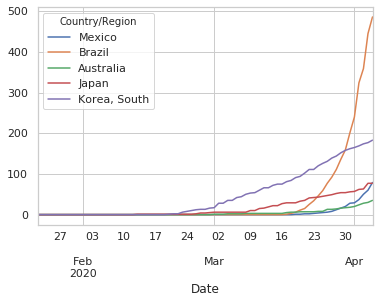

In [7]:
dfw[["Mexico", "Brazil", "Australia", "Japan", "Korea, South"]].plot(logy=False)

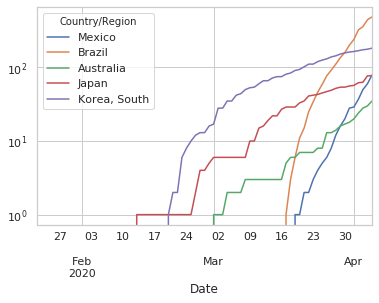

In [8]:
dfw[["Mexico", "Brazil", "Australia", "Japan", "Korea, South"]].plot(logy=True)

In [9]:
dfw_new_per_day = get_new_per_day(dfw)
dfw_new_per_day.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


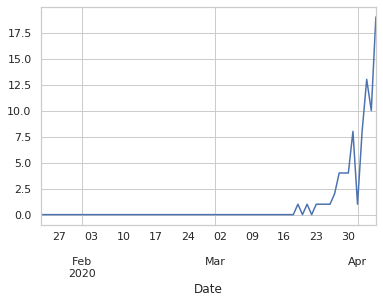

In [10]:
dfw_new_per_day['Mexico'].plot()

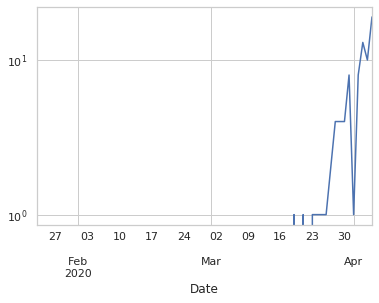

In [11]:
dfw_new_per_day['Mexico'].plot(logy=True)

In [12]:
def calculate_new_per_period(df_new_per_day, PERIOD=7):
    new_per_period = {}
    for country in df_new_per_day.columns:
        d = df_new_per_day[country]
        cum = [sum(d[(i-PERIOD):i]) for i in range(PERIOD, len(d))]
        new_per_period[country] = cum
    return new_per_period

In [13]:
def cum_and_new_from_init(dfw, new_per_period, country, INIT=99):
    d = dfw[country]
    cum_from_init = d[d>INIT]
    new_from_init = new_per_period[country][-len(cum_from_init):]
    assert len(cum_from_init) == len(new_from_init)
    return cum_from_init, new_from_init

In [14]:
dfw.columns[dfw.columns.str.contains("Korea")]

Index(['Korea, South'], dtype='object', name='Country/Region')

Text(0, 0.5, 'new cases last days')

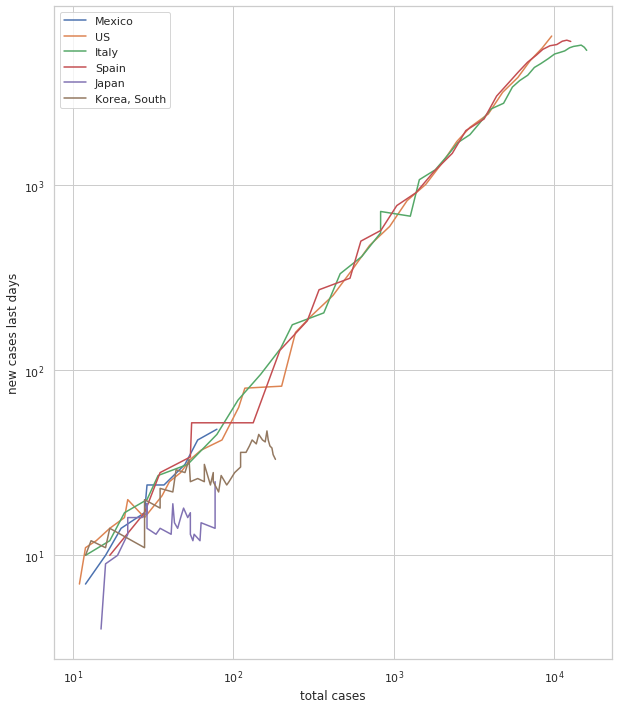

In [15]:
new_per_period = calculate_new_per_period(dfw_new_per_day, PERIOD=7)
countries = ['Mexico', 'US', 'Italy', 'Spain', 'Japan', 'Korea, South']

#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in countries:
    cum, new = cum_and_new_from_init(dfw, new_per_period, country, INIT=10)
    plt.plot(cum, new)
plt.legend(countries)
plt.xlabel("total cases")
plt.ylabel("new cases last days")

# México

In [16]:
dfmx = get_sinave_eduardofv('confirmados')
dfmx_descartados = get_sinave_eduardofv('descartados')
dfmx_probables = get_sinave_eduardofv('probables')
dfmx.head(10)

https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_confirmados.csv
https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_descartados.csv
https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_probables.csv


Estado,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatán,Zacatecas
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,24,27,13,3,11,6,205,39,2,7,...,43,25,24,17,38,8,4,26,46,6
2020-03-31,36,35,17,5,13,7,234,44,2,7,...,47,25,27,17,48,8,4,27,49,6
2020-04-01,36,37,18,5,14,11,296,57,3,7,...,51,31,32,18,52,9,5,28,52,6
2020-04-02,47,40,19,5,15,11,327,62,3,8,...,56,33,42,21,62,13,5,29,53,7
2020-04-03,48,52,21,6,18,12,384,70,4,8,...,65,35,51,22,73,16,8,35,59,7
2020-04-04,49,54,27,8,19,13,469,72,4,10,...,75,35,74,27,83,20,9,37,62,10
2020-04-05,49,69,28,8,25,15,560,82,4,12,...,86,37,90,28,97,26,11,40,67,10


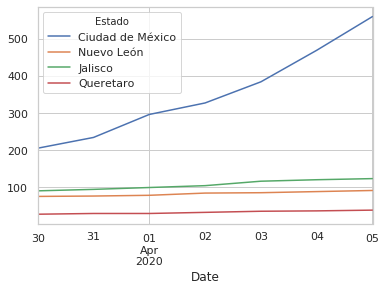

In [17]:
estados = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
dfmx[estados].plot(logy=False)

In [18]:
total_mx = dfmx.sum(axis=1)
total_mx

Date
2020-03-30    1094
2020-03-31    1215
2020-04-01    1378
2020-04-02    1510
2020-04-03    1688
2020-04-04    1890
2020-04-05    2143
dtype: int64

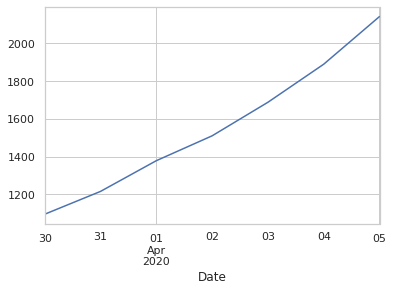

In [19]:
total_mx.plot()

In [20]:
dfmx_new_per_day = get_new_per_day(dfmx)
dfmx_new_per_day.head()

,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatán,Zacatecas
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,12,8,4,2,2,1,29,5,0,0,...,4,0,3,0,10,0,0,1,3,0
2020-04-01,0,2,1,0,1,4,62,13,1,0,...,4,6,5,1,4,1,1,1,3,0
2020-04-02,11,3,1,0,1,0,31,5,0,1,...,5,2,10,3,10,4,0,1,1,1
2020-04-03,1,12,2,1,3,1,57,8,1,0,...,9,2,9,1,11,3,3,6,6,0
2020-04-04,1,2,6,2,1,1,85,2,0,2,...,10,0,23,5,10,4,1,2,3,3


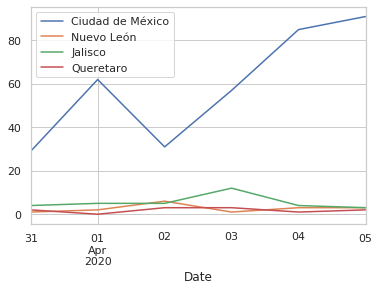

In [21]:
for estado in estados:
    dfmx_new_per_day[estado].plot()
plt.legend(estados)

In [22]:
total_probables = dfmx_probables.sum(axis=1)
total_descartados = dfmx_descartados.sum(axis=1)
total_pruebas = total_mx + total_probables + total_descartados
prop_confirmados = total_mx / total_pruebas
prop_confirmados

Date
2020-03-30    0.115389
2020-03-31    0.110374
2020-04-01    0.112233
2020-04-02    0.107973
2020-04-03    0.107612
2020-04-04    0.109986
2020-04-05    0.118831
dtype: float64

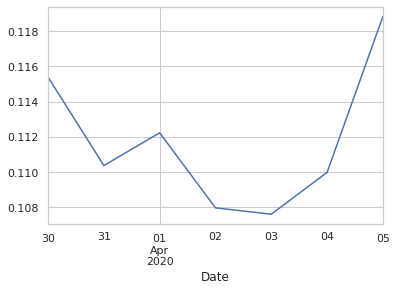

In [23]:
prop_confirmados.plot()